In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from shapely import wkt
import json
import os
import ast
from pandarallel import pandarallel
pandarallel.initialize()


# TODO will we predict just the edifc_uso or also edifc_stat & edifc_ty?
# TODO get the dictionary w/ definitions for edifc_uso

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [20]:
def load_multiple_csv_from_path(path, **kwargs):
    files = [f for f in os.listdir(path) if f.endswith("csv")]
    dfs = []
    for file in files[:20]:
        dfs.append(pd.read_csv(os.path.join(path, file), **kwargs).drop(columns=['edifc_stat', 'edifc_ty', 'footprint_geometry', 'points_geometry']).dropna())
    return pd.concat(dfs)

In [21]:
# Load dataset -> s w/ rows 
# TODO read whole dataset properly

dataset = load_multiple_csv_from_path("data/postgis_output/", dtype={'edifc_uso': object})
#dataset['points_geometry'] = dataset.points_geometry.parallel_apply(wkt.loads)
#dataset['footprint_geometry'] = dataset.footprint_geometry.parallel_apply(wkt.loads)
dataset['points'] = dataset.points.parallel_apply(lambda x: ast.literal_eval(x))

with open("edifc_uso_general.json", "r") as f:
    edifc_uso_mapping = json.load(f)  
dataset["edifc_uso_desc"] = dataset["edifc_uso"].map(edifc_uso_mapping)

# dataset = pd.read_pickle("cached_dataset_wout_points.pkl")

In [14]:
#dataset.drop(columns=['points']).to_pickle("cached_dataset_wout_points.pkl")

In [ ]:
lengths_array = dataset.points.parallel_apply(lambda x: len(x))

,footprint_id,edifc_uso,max_in_footprint,percentile_20_in_footprint,percentile_40_in_footprint,percentile_60_in_footprint,percentile_80_in_footprint,min_overrall,building_height,roof_height,footprint_area,edifc_uso_desc
0,162.0,1002,162.55,160.720,161.520,161.982,162.272,157.56,4.99,1.030,176.673487,ricreativo
1,1920.0,08,155.75,155.570,155.620,155.640,155.670,153.07,2.68,0.130,34.536128,industriale
2,2736.0,1002,156.95,155.662,155.992,156.280,156.608,151.52,5.43,0.958,104.149623,ricreativo
3,4501.0,1002,159.60,152.470,152.602,152.710,152.988,148.77,10.83,6.998,24.108268,ricreativo
4,5047.0,1002,157.31,156.390,156.410,156.440,156.470,152.11,5.20,0.900,898.891243,ricreativo
...,...,...,...,...,...,...,...,...,...,...,...,...
40,69653.0,08,181.99,181.760,181.790,181.810,181.830,176.20,5.79,0.200,61.038554,industriale
41,70196.0,95,184.53,178.732,178.774,178.840,181.326,176.61,7.92,5.756,13.570175,altro
42,70911.0,08,183.73,179.890,179.920,179.940,179.990,177.97,5.76,3.810,98.532883,industriale
43,72076.0,01,185.24,182.910,183.230,183.650,184.170,176.39,8.85,2.010,148.570402,residenziale


In [ ]:
dataset.shape

(14545, 12)

In [ ]:
from scipy.interpolate import LinearNDInterpolator
import requests
import math
import matplotlib.image as mpimg
from matplotlib import rcParams

def plot_points(x, y, z, ax):
        X = np.linspace(min(x), max(x), num=200)
        Y = np.linspace(min(y), max(y), num=200)
        X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
        interp = LinearNDInterpolator(list(zip(x, y)), z)
        Z = interp(X, Y)
        ax.pcolormesh(X, Y, Z, shading='auto', cmap="viridis")
        ax.legend()
        ax.axis("equal")
        ax.plot(np.median(x), np.median(y), color='red', marker='o', markersize=20)

def plot_footprint(footprint, ax):
        for poly in footprint.geoms:
                ax.plot(*poly.exterior.xy, color="red", linewidth=3)


def show_satellite_image(x, y, ax, zoom = 19):
        # Mapbox access token
        access_token = 'pk.eyJ1IjoibWF0dGVvYmlnbGlvbGkiLCJhIjoiY2txcGN0cmJ5MDBqdTJvazV6cXdiM2ZqOSJ9.Bd6Gd05464fMSOpqCB-uTw'

        # Define the Mapbox API endpoint for creating a static map
        center_x = np.median(x)
        center_y = np.median(y)
        url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/pin-l+f41010({center_x},{center_y})/{center_x},{center_y},18.55,0/512x512@2x?access_token={access_token}"
        # Send the API request and get the image
        with open("satellite_image.jpeg", 'wb') as f:
                f.write(requests.get(url).content)

        satellite_image = mpimg.imread('satellite_image.jpeg', format="jpeg")
        ax.imshow(satellite_image)

def show_dataset_sample(footprint, points):
        x, y, z = map(np.array, zip(*points))
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))

        plot_points(x, y, z, ax[0])
        plot_footprint(footprint, ax[0])
        show_satellite_image(x, y, ax[1])

        plt.draw()


In [ ]:
# Show dataset example
example_n = 10
points = list(dataset["points"])[example_n]
footprint = list(dataset["footprint_geometry"])[example_n]
show_dataset_sample(footprint, points)

KeyError: 'points'

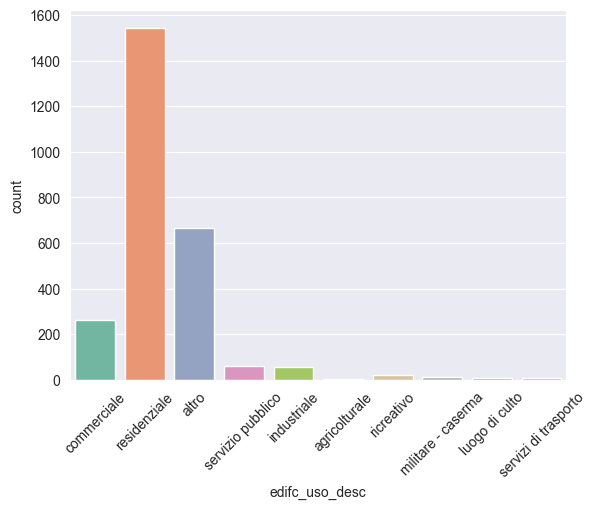

In [6]:
# Check if dataset is balanced
sn.set_style('darkgrid')
sn.countplot(x = "edifc_uso_desc", data = dataset, palette="Set2") 
plt.xticks(rotation=45)
plt.show()

In [7]:
# Suppose to include 'altro', 'commerciale', 'industriale', 'residenziale', 'servizio pubblico'
def balance_dataset(dataset):
    edifc_uso_desc_to_include = ['altro', 'commerciale', 'industriale', 'residenziale', 'servizio pubblico']
    dataset_to_balance = dataset[dataset["edifc_uso_desc"].isin(edifc_uso_desc_to_include)]
    
    min_n_rows = min(dataset_to_balance.groupby(["edifc_uso_desc"]).size())

    dfs = []
    for edifc_uso in edifc_uso_desc_to_include:
        dfs.append(dataset[dataset["edifc_uso_desc"] == edifc_uso].sample(n=min_n_rows))
    return pd.concat(dfs)

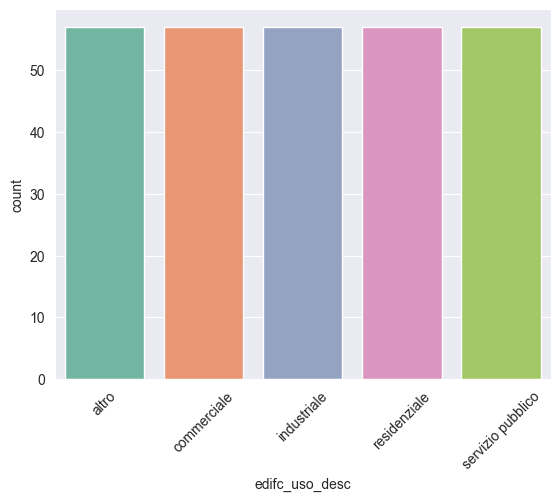

In [8]:
# Dataset won't be balanced => make it balanced
balanced_dataset = balance_dataset(dataset)
sn.set_style('darkgrid')
sn.countplot(x = "edifc_uso_desc", data = balanced_dataset, palette="Set2") 
plt.xticks(rotation=45)
plt.show()

In [9]:
# Extract features -> Done in postgis

# TODO Slope on a grid over the footprint
# TODO Numer of relative Max/Min
# TODO Proximity of other footprints

In [15]:
# Plot data as vectors
import umap.umap_ as umap

def plot_vectors(X, y, title="Plot"):
    # Prepare data in 2d for visualization purposes # TODO add random state
    umap_data = umap.UMAP(n_components=2, metric='cosine').fit_transform(X)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(result.x, result.y, c=y, s=1, cmap='hsv_r')
    plt.colorbar()
    plt.title(title, {'fontsize': 15})
    plt.show()

In [16]:
# Prepare data for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

feature_cols = ['max_in_footprint', 'percentile_20_in_footprint', 'percentile_40_in_footprint', 'percentile_60_in_footprint',
       'percentile_80_in_footprint', 'min_overrall', 'building_height', 'roof_height', 'footprint_area']
X = balanced_dataset[feature_cols].values

edifc_uso_descs = np.unique(list(balanced_dataset["edifc_uso_desc"]))
oe = OrdinalEncoder(categories = [edifc_uso_descs])
y = oe.fit_transform(balanced_dataset[["edifc_uso_desc"]])

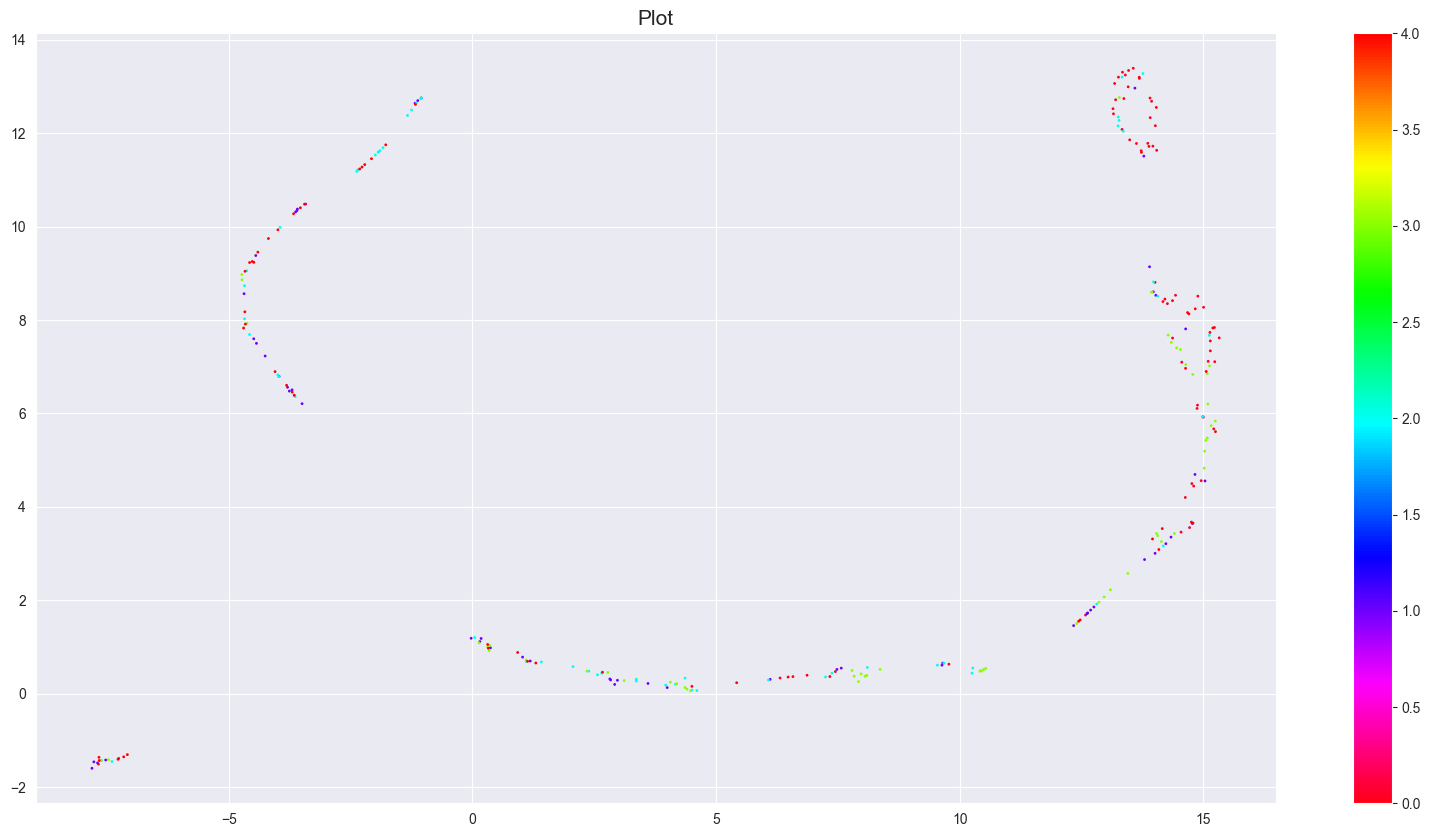

In [17]:
plot_vectors(X, y)

# K-nn

In [18]:
# Prepare data for ML
# TODO in a way for which they are balanced w/ respect to the class? (all residential in train and all commercial in test?)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42,stratify=y)

In [19]:
# Classify w/ features - Knn
from sklearn.neighbors import KNeighborsClassifier as kNN

knn = kNN(n_neighbors=3)
type(knn)

knn.fit(X_train, y_train)
print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.672514619883041 0.2894736842105263


/Users/billy/Documents/university/dse/statistical_methods_for_machine_learning/MSA/.venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [20]:
# TODO check ravel()
from sklearn.model_selection import learning_curve

sizes = range(100, 200, 50)
train_size, train_score, val_score = learning_curve(kNN(n_neighbors=7), X, y.ravel(), train_sizes=sizes, cv=5)

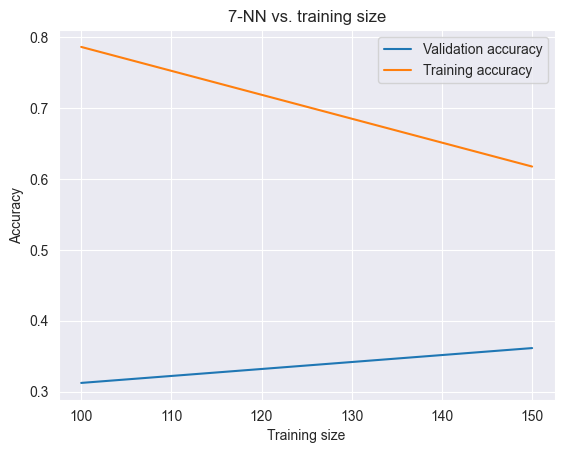

In [21]:
plt.title('7-NN vs. training size')
plt.plot(train_size, np.mean(val_score, 1), label='Validation accuracy')
plt.plot(train_size, np.mean(train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [22]:
from sklearn.model_selection import validation_curve

neighbors = range(1,200,20)
train_score, val_score = validation_curve(kNN(), X, y.ravel(), param_name='n_neighbors', param_range=neighbors, cv=5)

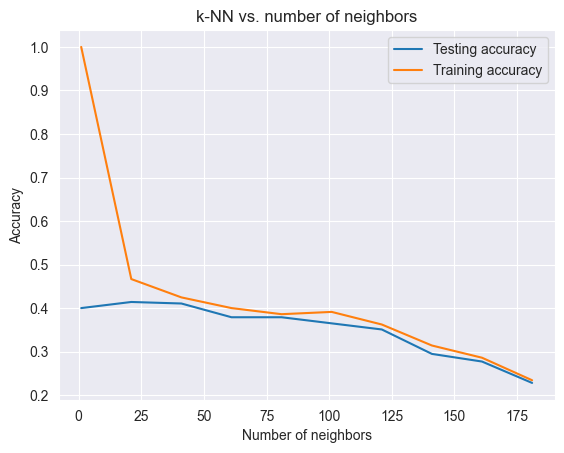

In [23]:
plt.title('k-NN vs. number of neighbors')
plt.plot(neighbors, np.mean(val_score, 1), label='Testing accuracy')
plt.plot(neighbors, np.mean(train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

learner = DecisionTreeClassifier(criterion='gini')

learner.fit(X_train, y_train)
y_pred = learner.predict(X_test)
test_score = accuracy_score(y_test,y_pred)
np.round(test_score, decimals=2)

0.44

In [25]:
int(learner.tree_.node_count), int(learner.tree_.max_depth)

(117, 11)

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(learner, X, y, cv=5)
np.round(scores.mean(), decimals=2)

0.42

In [28]:
learner = DecisionTreeClassifier(criterion='entropy')

scores = cross_val_score(learner, X, y, cv=5)
np.round(scores.mean(), decimals=2)

0.38

In [30]:
sizes = range(10, 190, 10)
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=3)

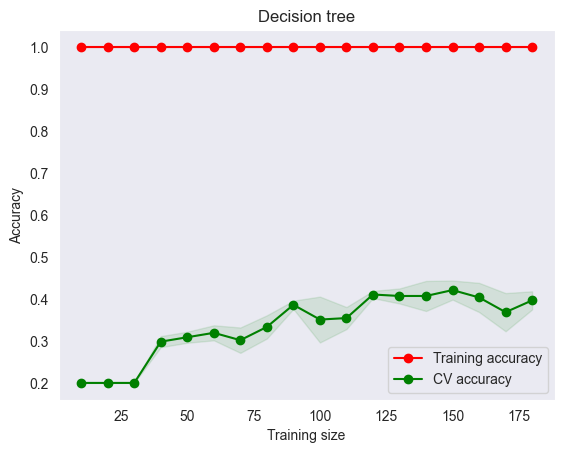

In [31]:
plt.title('Decision tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training accuracy")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [32]:
depths = np.arange(1,33,5)
learner = DecisionTreeClassifier()
train_score, val_score = validation_curve(learner, X, y, param_name='max_depth', param_range=depths, cv=3)

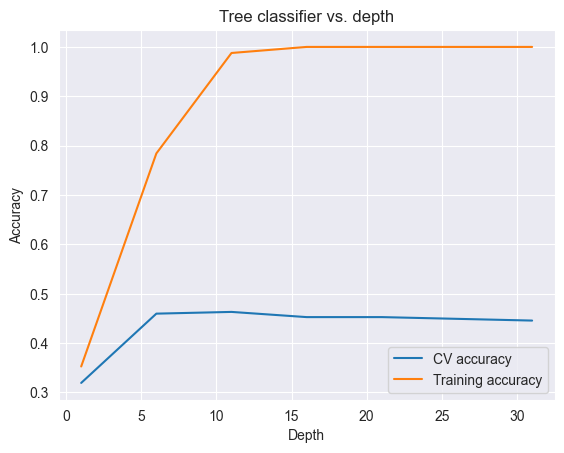

In [33]:
plt.title('Tree classifier vs. depth')
plt.plot(depths, np.mean(val_score, 1), label='CV accuracy')
plt.plot(depths, np.mean(train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

In [46]:
from sklearn.ensemble import BaggingClassifier

tree_lrn = DecisionTreeClassifier()
bag_lrn = BaggingClassifier(estimator=tree_lrn, n_estimators=10)
sizes = range(10, 190, 10)
train_size, train_score, val_score = learning_curve(bag_lrn, X, y.ravel(), train_sizes=sizes, cv=3)

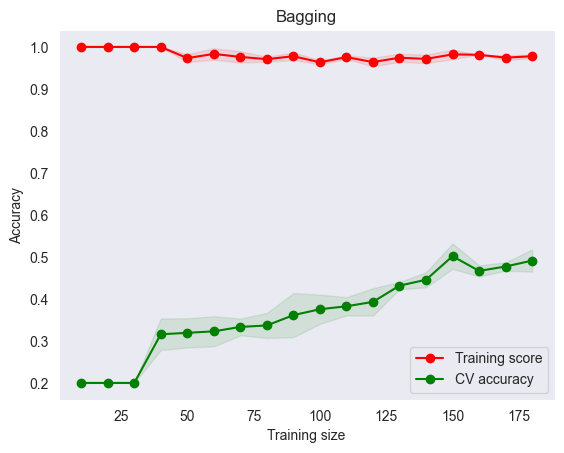

In [35]:
plt.title('Bagging')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_lrn = RandomForestClassifier(n_estimators=10, max_depth=10)
sizes = range(10, 190, 10)
train_size, train_score, val_score = learning_curve(rf_lrn, X, y.ravel(), train_sizes=sizes, cv=3)

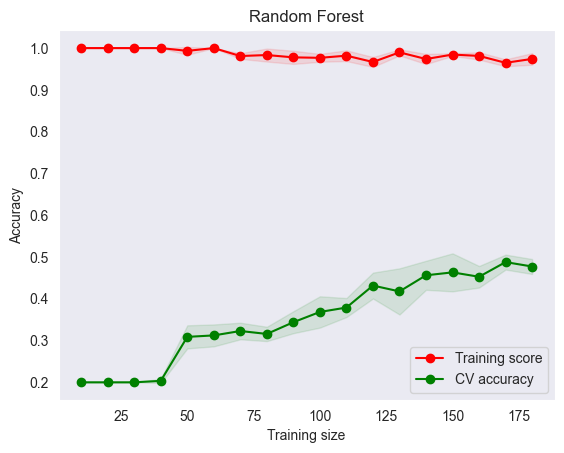

In [38]:
plt.title('Random Forest')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

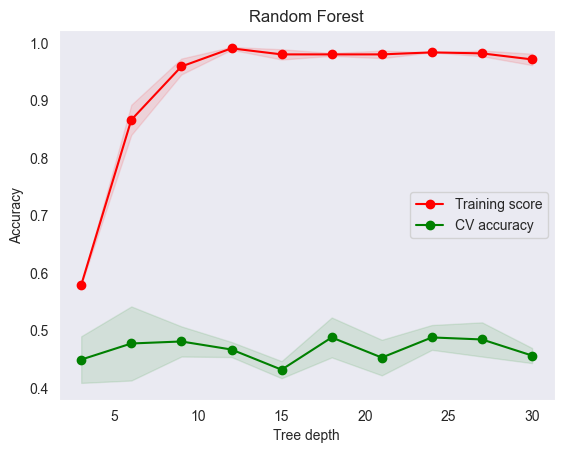

In [40]:
# We now investigate how the depth of the trees affects the performance of Random Forest. We explore a range of depths from 3 to 30

depths = np.arange(3,31,3)
learner = RandomForestClassifier(n_estimators=10)
train_score, val_score = validation_curve(learner, X, y.ravel(), param_name='max_depth', param_range=depths, cv=3)

plt.title('Random Forest')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(depths, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(depths, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(depths, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(depths, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.show()

In [44]:
num_trees = [1,10,100]
tree_lrn = DecisionTreeClassifier()
bag_lrn = BaggingClassifier(estimator=tree_lrn)
rf_lrn = RandomForestClassifier(max_depth=15)
train_score, bag_val_score = validation_curve(bag_lrn, X, y.ravel(), 
                                              param_name='n_estimators',
                                              param_range=num_trees,
                                              cv=3)
train_score, rf_val_score = validation_curve(rf_lrn, X, y.ravel(),
                                             param_name='n_estimators',
                                             param_range=num_trees,
                                             cv=3)

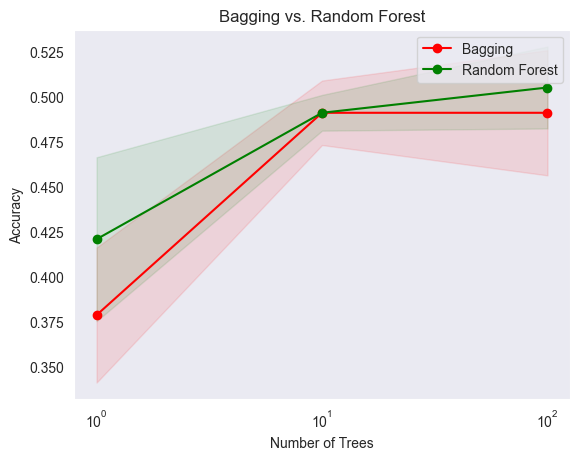

In [45]:
plt.title('Bagging vs. Random Forest')
bag_val_score_mean = np.mean(bag_val_score, axis=1)
bag_val_score_std = np.std(bag_val_score, axis=1)
rf_val_score_mean = np.mean(rf_val_score, axis=1)
rf_val_score_std = np.std(rf_val_score, axis=1)
plt.grid()
plt.xscale("log")
plt.fill_between(num_trees, bag_val_score_mean - bag_val_score_std,
                 bag_val_score_mean + bag_val_score_std, alpha=0.1,
                 color="r")
plt.fill_between(num_trees, rf_val_score_mean - rf_val_score_std,
                 rf_val_score_mean + rf_val_score_std, alpha=0.1, color="g")
plt.plot(num_trees, bag_val_score_mean, 'o-', color="r",
         label="Bagging")
plt.plot(num_trees, rf_val_score_mean, 'o-', color="g",
         label="Random Forest")
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

# Cnn

In [59]:
#import utilities as ff
from tensorflow import config as tfconfig
from tensorflow.python.client import device_lib
try:
    print(tfconfig.list_physical_devices())
    print(device_lib.list_local_devices())
except:
    pass

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16825231888120607380
xla_global_id: -1
]


In [ ]:
def BASE():
    model = Sequential()
    model.add(Rescaling(1.0 / 255))
    model.add(
        Conv2D(
            filters=16,
            kernel_size=3,
            padding=padding,
            activation=activation,
        )
    )
    model.add(MaxPooling2D())
    model.add(
        Conv2D(
            filters=32,
            kernel_size=3,
            padding=padding,
            activation=activation,
        )
    )
    model.add(MaxPooling2D())
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            padding=padding,
            activation=activation,
        )
    )
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(
        Dense(
            units=64,
            activation=activation,
        )
    )
    model.add(
        Dense(
            units=8,
            activation=activation,
        )
    )
    model.add(Dense(2))
    return model


# Results and Comparison

In [ ]:
# Results and comparison